## Описание проекта

Необходимо подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.

# 1. Подготовка данных

Загрузим необходимые библиотеки и функции.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Прочтем данные.

In [2]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Проверим правильность расчета эффективности обогащения. Вычислим её по формуле и найдем MAE между вычислениями и значениями 'rougher.output.recovery'. Только сначала избавимся от значений NaN и проведем соответствие между оставшимися значениями.

In [3]:
test_recovery = (
        gold_train['rougher.output.concentrate_au'] * 
        (gold_train['rougher.input.feed_au'] - gold_train['rougher.output.tail_au']) /
        gold_train['rougher.input.feed_au'] / 
        (gold_train['rougher.output.concentrate_au'] - gold_train['rougher.output.tail_au']) * 100
)

test_recovery = test_recovery.dropna()
recovery = gold_train['rougher.output.recovery'].dropna()
mean_absolute_error(recovery, test_recovery[recovery.index])

1.0512313043960013e-14

MAE исчезающе мало, практически равно нулю, эффективность обогащения посчитана правильно.

Посмотрим на признаки, недоступные в тестовой выборке.

In [4]:
set(gold_train.columns) - set(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Как видим, тестовая выборка не содержит параметры продуктов на выходе после каждого этапа и расчетные характеристики. Эти признаки появляются в ходе процесса или расчитываются на основе исходных параметров и сами по себе не влияют на целевой признак, поэтому эти столбцы (за исключением двух таргетов) можно смело удалить из обучающей выборки. Также можно удалить столбец с датой.

In [5]:
numeric = list(set(gold_train.columns) - set(gold_test.columns))
numeric.remove('final.output.recovery')
numeric.remove('rougher.output.recovery')
gold_train = gold_train.drop(numeric, axis=1)
gold_train = gold_train.drop('date', axis=1).dropna()

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов после каждого этама очистки.

In [6]:
print('После флотации:')
print("Увеличение концентрации золота:", 
      gold_full['rougher.output.concentrate_au'].mean() / gold_full['rougher.input.feed_au'].mean())
print("Увеличение концентрации серебра:", 
      gold_full['rougher.output.concentrate_ag'].mean() / gold_full['rougher.input.feed_ag'].mean())
print("Увеличение концентрации свинца:", 
      gold_full['rougher.output.concentrate_pb'].mean() / gold_full['rougher.input.feed_pb'].mean())
print()
print('После первичной очистки:')
print("Увеличение концентрации золота:", 
      gold_full['primary_cleaner.output.concentrate_au'].mean() / gold_full['rougher.output.concentrate_au'].mean())
print("Увеличение концентрации серебра:", 
      gold_full['primary_cleaner.output.concentrate_ag'].mean() / gold_full['rougher.output.concentrate_ag'].mean())
print("Увеличение концентрации свинца:", 
      gold_full['primary_cleaner.output.concentrate_pb'].mean() / gold_full['rougher.output.concentrate_pb'].mean())
print()
print('После вторичной очистки:')
print("Увеличение концентрации золота:", 
      gold_full['final.output.concentrate_au'].mean() / gold_full['primary_cleaner.output.concentrate_au'].mean())
print("Увеличение концентрации серебра:", 
      gold_full['final.output.concentrate_ag'].mean() / gold_full['primary_cleaner.output.concentrate_ag'].mean())
print("Увеличение концентрации свинца:", 
      gold_full['final.output.concentrate_pb'].mean() / gold_full['primary_cleaner.output.concentrate_pb'].mean())

После флотации:
Увеличение концентрации золота: 2.363193446719693
Увеличение концентрации серебра: 1.3482354981012192
Увеличение концентрации свинца: 2.0875145115084206

После первичной очистки:
Увеличение концентрации золота: 1.6338391053777537
Увеличение концентрации серебра: 0.7073119004434527
Увеличение концентрации свинца: 1.2927933920107584

После вторичной очистки:
Увеличение концентрации золота: 1.3693268714333477
Увеличение концентрации серебра: 0.6216557377038314
Увеличение концентрации свинца: 1.019526523936323


Итак, концентрация золота на каждом этапе увеличивается. Также незначительно увеличивается содержание свинца, а вот содержание серебра сначала тоже увеличивается, а после певого и второго этапа очистки уменьшается.  
Но наша цель - золото, так что серебром пренебрежем.

Посмотрим на распределение размеров гранул в обучающей и тестовой выборках.

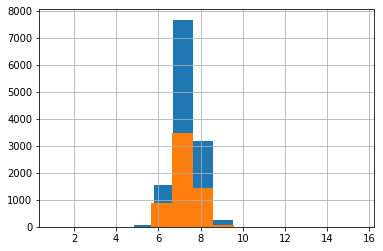

In [7]:
gold_train['primary_cleaner.input.feed_size'].hist();
gold_test['primary_cleaner.input.feed_size'].hist();

Распределения совпадают, значит оценка модели должна быть адекватной.

Посмотрим на распределение суммарной концентрации веществ на различных стадиях процесса.

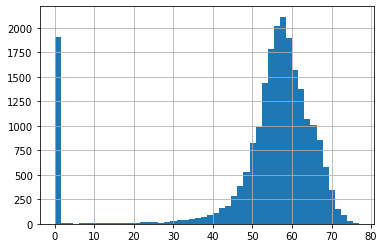

In [8]:
(gold_full['rougher.input.feed_au'] + 
 gold_full['rougher.input.feed_ag'] + 
 gold_full['rougher.input.feed_pb'] +
 gold_full['rougher.input.feed_sol']
).hist(bins=50);

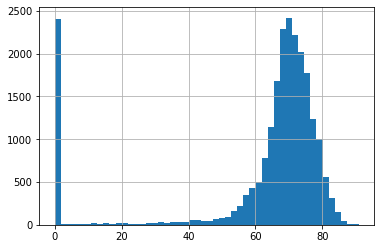

In [9]:
(gold_full['rougher.output.concentrate_au'] + 
 gold_full['rougher.output.concentrate_ag'] + 
 gold_full['rougher.output.concentrate_pb'] +
 gold_full['rougher.output.concentrate_sol']
).hist(bins=50);

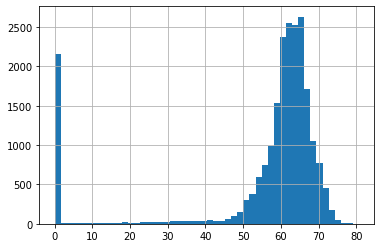

In [10]:
(gold_full['primary_cleaner.output.concentrate_au'] + 
 gold_full['primary_cleaner.output.concentrate_ag'] + 
 gold_full['primary_cleaner.output.concentrate_pb'] +
 gold_full['primary_cleaner.output.concentrate_sol']
).hist(bins=50);

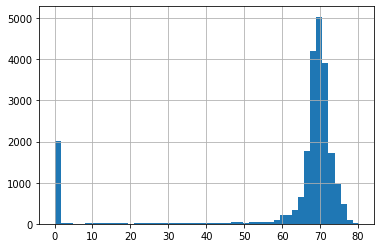

In [11]:
(gold_full['final.output.concentrate_au'] + 
 gold_full['final.output.concentrate_ag'] + 
 gold_full['final.output.concentrate_pb'] +
 gold_full['final.output.concentrate_sol']
).hist(bins=50);

На всех стадиях явно заметна аномалия в районе нулевой отметки. Эта аномалия скорее всего негативно скажется на обучении модели, поэтому лучше эти значения удалить.

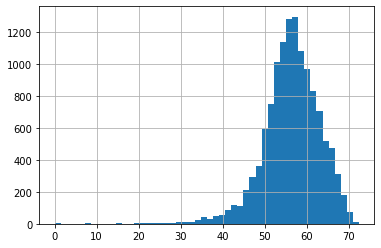

In [12]:
gold_train['sum'] = (
    gold_train['rougher.input.feed_au'] + 
    gold_train['rougher.input.feed_ag'] + 
    gold_train['rougher.input.feed_pb'] +
    gold_train['rougher.input.feed_sol']
)
gold_train = gold_train.query('sum>0')
gold_train['sum'].hist(bins=50);

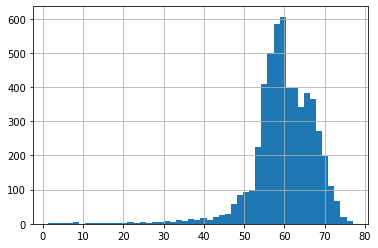

In [13]:
gold_test['sum'] = (
    gold_test['rougher.input.feed_au'] + 
    gold_test['rougher.input.feed_ag'] + 
    gold_test['rougher.input.feed_pb'] +
    gold_test['rougher.input.feed_sol']
)
#gold_test = gold_test.query('sum>0').dropna()
gold_test = gold_test.query('sum>0')
gold_test['sum'].hist(bins=50);

In [14]:
gold_train = gold_train.drop('sum', axis=1)
gold_test = gold_test.drop('sum', axis=1)

Аномалия удалена можно приступать к обучению модели.

# 3. Модель

У нас два целевых признака.

In [15]:
features = gold_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_1 = gold_train['rougher.output.recovery']
target_2 = gold_train['final.output.recovery']

Напишем функцию для расчета sMAPE и сделаем её метрикой.

In [16]:
def smape(target, predict):
    smape = (abs(target - predict) / (abs(target) + abs(predict)) * 2).sum() / len(target)
    return smape

scorer = make_scorer(smape)

Теперь напишем функцию для расчета итогового sMAPE. 

In [17]:
def final_smape(model):
    score_1 = cross_val_score(model, features, target_1, cv=3, scoring=scorer).mean()
    score_2 = cross_val_score(model, features, target_2, cv=3, scoring=scorer).mean()
    full_score = 0.25*score_1 + 0.75*score_2
    return full_score

Посчитаем лучший скор для решающего дерева с перебором параметров.  
ПРИ ТЕСТИРОВАНИИ ПАРАМЕТР max_depth МЕНЯЛСЯ В ДИАПАЗОНЕ (1, 11, 1). ВРЕМЯ РАБОТЫ ЦИКЛОВ СОСТАВЛЯЛО 28 МИН., А РЕЗУЛЬТАТ БЫЛ ТАКИМ ЖЕ, ПОЭТОМУ ДЛЯ ДЕМОНСТРАЦИИ КОЛИЧЕСТВО ИТЕРАЦИЙ СОКРАЩЕНО.

In [18]:
%%time
full_score_min = 1
crit_list = ['mse', 'friedman_mse', 'mae']
split_list = ['best', 'random']
for crit in crit_list:
    for split in split_list:
        for depth in range(1, 3, 1):
            model = DecisionTreeRegressor(criterion=crit, splitter=split, random_state=12345, max_depth=depth)
            full_score = final_smape(model)
            if full_score < full_score_min:
                full_score_min = full_score
                dep = depth
                cr = crit
                spl = split
print('Наименьшее значение итогового sMAPE {:.2%}'.format(full_score_min), 'при:')
print('max_depth =', dep)
print('splitter =', spl)
print('criterion =', cr)

Наименьшее значение итогового sMAPE 10.34% при:
max_depth = 1
splitter = best
criterion = mae
CPU times: user 3min 18s, sys: 91.4 ms, total: 3min 18s
Wall time: 3min 19s


Теперь то же для случайного леса.  
ПРИ ТЕСТИРОВАНИИ ПАРАМЕТР max_depth МЕНЯЛСЯ В ДИАПАЗОНЕ (1, 11, 1), ПАРАМЕТР n_estimators - В ДИАПАЗОНЕ(10,101,10). ВРЕМЯ РАБОТЫ ЦИКЛОВ СОСТАВЛЯЛО ОКОЛО 1.5 ЧАСОВ, А РЕЗУЛЬТАТ БЫЛ ТАКИМ ЖЕ, ПОЭТОМУ ДЛЯ ДЕМОНСТРАЦИИ КОЛИЧЕСТВО ИТЕРАЦИЙ СОКРАЩЕНО.

In [19]:
%%time
full_score_min = 1
for estim in range(10, 31, 10):
    for depth in range(1, 3, 1):
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        full_score = final_smape(model)
        if full_score < full_score_min:
            full_score_min = full_score
            est = estim
            dep = depth
print('Наименьшее значение итогового sMAPE {:.2%}'.format(full_score_min), 'при:')
print('max_depth =', dep)
print('n_estimators =', est)

Наименьшее значение итогового sMAPE 10.25% при:
max_depth = 1
n_estimators = 10
CPU times: user 38.7 s, sys: 48 ms, total: 38.8 s
Wall time: 39.2 s


Наконец посчитаем наш скор для линейной регрессии.

In [20]:
model = LinearRegression()
print('Итоговый sMAPE {:.2%}'.format(final_smape(model)))

Итоговый sMAPE 12.06%


sMAPE характеризует отклонение предсказания от таргета, поэтому чем оно меньше, тем лучше. Здесь победил лес. Проверим его на тесте, но сначала подтянем целевые признаки для тестовой выборки из полной и избавимся от NaN-ов.

In [21]:
gold_test.index = gold_test['date']
gold_full.index = gold_full['date']
gold_test['rougher.output.recovery'] = gold_full['rougher.output.recovery'][gold_test.index]
gold_test['final.output.recovery'] = gold_full['final.output.recovery'][gold_test.index]
gold_test = gold_test.dropna()

features = gold_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_1 = gold_test['rougher.output.recovery']
target_2 = gold_test['final.output.recovery']

model = RandomForestRegressor(n_estimators=10, max_depth=1, random_state=12345)
print('Итоговый sMAPE {:.2%}'.format(final_smape(model)))

Итоговый sMAPE 8.88%


Попробуем сравнить наш результат с результатом, полученным для константной модели (возьмем медианное значение для каждого таргета из обучающей выборки)

In [22]:
prediction_1 = pd.Series(gold_train['rougher.output.recovery'].median(), target_1.index)
prediction_2 = pd.Series(gold_train['final.output.recovery'].median(), target_2.index)
smape_1 = smape(target_1, prediction_1)
smape_2 = smape(target_2, prediction_2)
full_smape = 0.25*smape_1 + 0.75*smape_2
print('Итоговый sMAPE константной модели {:.2%}'.format(full_smape))

Итоговый sMAPE константной модели 9.08%


Итак, наша лучшая модель все-таки обошла константную, хотя и не слишком сильно. Достаточно большая точность константной модели говорит о небольшом разбросе параметра относительно медианы. Тем не менее нашу модель всё же можно рекомендовать в качестве прогностической.